In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')
#sys.path.append('/media/cjw/PythonLib/Unet')
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
import unet2d

%matplotlib inline

/home/cjw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cjw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cjw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
/home/cjw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/cjw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Ex

In [2]:
import tensorflow as tf

In [3]:
params = dict()

params['width'] = 256
params['height'] = 256
params['nchannels'] = 3
params['channels'] = [0,1,2]
params['nepochs'] = [1]
params['batchsize'] = [512]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
params['enc_sizes'] = [[16,5, 2], [32, 3, 2],
                       [64, 3, 2], [128, 3, 2], [256, 3, 2]]

## make the last layer nine images
params['dec_sizes'] = [[128,3, 2], [64, 3, 2],
                       [32, 3, 2], [16, 5, 2], [9, 3, 2]]
params['droprate'] = 0.1
params['stdev'] = 0.04

In [4]:
    
## read in the data
data_tif = imread('/ssd1/cjw/Data/sez/NDExp.tif')
labels_tif = imread('/ssd1/cjw/Data/sez/NDExp_labels.tif')
print(labels_tif.shape)

# rtemp = np.zeros(labels_tif.shape[0:3] + (2,))
# rtemp[:,:,:,0] = labels_tif[:,:,:,0] + labels_tif[:,:,:,2]
# rtemp[:,:,:,1] = labels_tif[:,:,:,1] + labels_tif[:,:,:,3]
# labels_tif = rtemp
#labels_tif = np.moveaxis(labels_tif, 1, -1)

#create the background channel for the labels
labshape = labels_tif.shape
temp = np.zeros(labels_tif.shape[0:3] + (labshape[-1] + 1,), dtype=np.float32)
temp[:,:, :, 0:-1] = labels_tif
tsum = labels_tif.max() - labels_tif.max(axis=(-1))
temp[:,:,:, -1] = tsum
labels_tif = temp


#normalize images 0-1
#try normalizing wit zero mean and equal sdev

dmin = data_tif.min(axis=(1,2),keepdims=True)
dmax = data_tif.max(axis=(1,2),keepdims=True)
dmean = data_tif.mean(axis=(1,2),keepdims=True)
dstd = data_tif.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
data = (data_tif - dmean)/dstd
labels = (labels_tif - labels_tif.min())/(labels_tif.max() - labels_tif.min())


#put cells with both channels into channel 0
lsum = labels.sum(axis=(-1))
s2 = lsum > 1
s2 = s2.astype(np.float32)
labels[:,:,:,1] -= s2
data_tif.shape, data.shape, labels.shape, labels_tif.shape, labels.min(), labels.max(), labels_tif.max(),labels_tif.min()

(9, 512, 512, 4)


((9, 512, 512, 3),
 (9, 512, 512, 3),
 (9, 512, 512, 5),
 (9, 512, 512, 5),
 0.0,
 1.0,
 255.0,
 0.0)

2.0


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

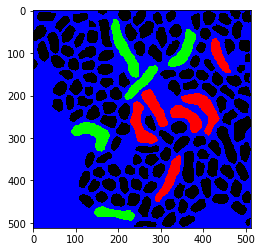

In [5]:
print(lsum[5].max())
plt.imshow(labels[-2,:,:,2:5]) #.sum(axis=-1))
labels.min(axis=(1,2))

(3, 512, 512) float32 float32


((9, 512, 512, 9), (9, 512, 512, 4))

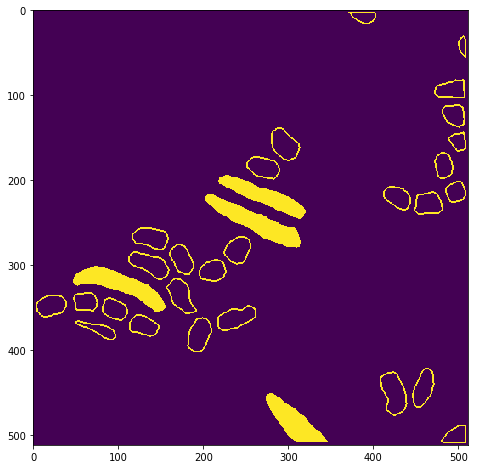

In [6]:

def get_outline(a, ch):
    
    b = a[:,:,ch] 
    b[np.where(b > 0)] = 1
    
    e0 = distance_transform_edt(b)
    ew = np.where(np.logical_and(e0 >= 1, e0 <=2))
    ew0 = np.zeros(b.shape, dtype=a.dtype)
    ew0[ew] = 1
    return ew0, ew

z = labels.copy()

ch4= np.zeros((labels.shape[0:-1] + (labshape[-1],)), dtype=np.float32)

for i in range(labels.shape[0]):
    ch = 0
    q0, qw0 = get_outline(labels[i], ch)
    z[i,:,:,0][qw0] = 0
    
    ch = 1
    q1, qw1 = get_outline(labels[i], ch)
    z[i,:,:,1][qw1] = 0
    
    ch = 2
    q2, qw2 = get_outline(labels[i], ch)
    z[i,:,:,2][qw2] = 0
    
    ch = 3
    q3, qw3 = get_outline(labels[i], ch)
    z[i,:,:,3][qw3] = 0
    
    ch4[i,:,:,0] = q0
    ch4[i,:,:,1] = q1
    ch4[i,:,:,2] = q2
    ch4[i,:,:,3] = q3

plt.figure(figsize=(8,8))
z = np.concatenate([z, ch4], axis=-1)
labels = z

lsum = labels.sum(axis=(-1))
s2 = lsum > 1
s2 = s2.astype(np.float32)
labels[:,:,:,1] -= s2 

print(labels[0,:,:,[0,1,3]].shape, ch4.dtype, labels.dtype)
plt.imshow(labels[5,:,:,2] + labels[5,:,:,5]) # + .5*labels[-1,:,:,4] + .25*labels[-1,:,:,-1])
labels.shape, labshape

0.0

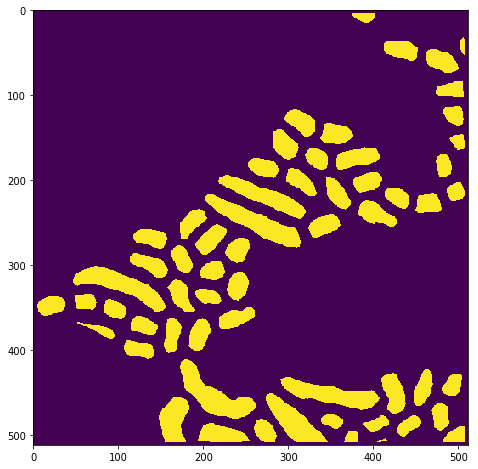

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(labels[5,:,:,0:4].sum(axis=-1))
#plt.plot(labels[5,:,:,0:4].sum(axis=-1)[220,:])
labels.min()

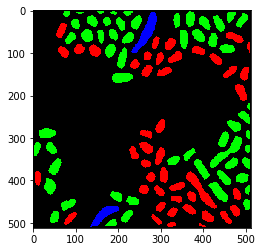

In [8]:
nv = -1
sh = [0,1,2]
pd = np.zeros((512, 512, 3), dtype=np.float32)
pd[:,:,0] = labels[nv, :,:,sh[0]]
pd[:,:,1] = labels[nv, :,:,sh[1]]
pd[:,:,2] = labels[nv ,:,:,sh[2]]
plt.imshow(pd)

In [9]:

tf.reset_default_graph()
u = unet2d.unet2d(params)
u.x = data
u.y = labels

In [10]:
test_images = imread('/ssd1/cjw/Data/sez/test.tif')
tmean = test_images.mean(axis=(1,2),keepdims=True)
tstd = test_images.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
test_images = (test_images - tmean)/tstd
u.xtest = test_images
print(test_images.std(axis=(1,2)))
u.xtest.shape, u.xtest.mean(axis=(1,2)).shape,u.xtest.mean(axis=(1,2)), u.xtest.min(axis=(1,2)), u.xtest.max(axis=(1,2))

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


((4, 512, 512, 3),
 (4, 3),
 array([[ 8.67361738e-19,  4.33680869e-18, -1.47451495e-17],
        [ 2.42861287e-17, -2.77555756e-17,  1.73472348e-18],
        [-1.02999206e-17,  9.75781955e-18, -2.94902991e-17],
        [ 6.50521303e-18, -8.67361738e-18,  1.73472348e-17]]),
 array([[-0.77434923, -0.67069198, -5.75321835],
        [-0.80996298, -0.51847166, -5.15309134],
        [-1.16963105, -0.85580761, -4.75164339],
        [-1.44531311, -0.77003683, -4.44155761]]),
 array([[ 6.24956098,  6.31317096,  7.96252817],
        [ 8.99004117,  7.3174952 ,  6.62614886],
        [ 6.19657008,  5.88927642,  6.74214584],
        [10.81873288, 10.72657588,  6.89048635]]))

In [11]:
w = 256

In [12]:
tf.reset_default_graph()
images = tf.placeholder(tf.float32, (None, w, w, params['nchannels']))
masks = tf.placeholder(tf.float32, (None, w, w, labels.shape[-1]))
learning_rate = tf.placeholder(tf.float32, ())
u.learning_rate = learning_rate

In [13]:
enc = u.create_encoder(images, True)

[16, 5, 2] <class 'int'>
[32, 3, 2] <class 'int'>
[64, 3, 2] <class 'int'>
[128, 3, 2] <class 'int'>
[256, 3, 2] <class 'int'>


In [14]:
d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

Tensor("decoder-layer-128/BiasAdd:0", shape=(?, 16, 16, 128), dtype=float32)
4 Tensor("Relu_7:0", shape=(?, 16, 16, 128), dtype=float32)
after concat Tensor("concat-128:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("Relu_8:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("decoder-layer-64/BiasAdd:0", shape=(?, 32, 32, 64), dtype=float32)
3 Tensor("Relu_5:0", shape=(?, 32, 32, 64), dtype=float32)
after concat Tensor("concat-64:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("Relu_9:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("decoder-layer-32/BiasAdd:0", shape=(?, 64, 64, 32), dtype=float32)
2 Tensor("Relu_3:0", shape=(?, 64, 64, 32), dtype=float32)
after concat Tensor("concat-32:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("Relu_10:0", shape=(?, 64, 64, 32), dtype=float32)
Tensor("decoder-layer-16/BiasAdd:0", shape=(?, 128, 128, 16), dtype=float32)
1 Tensor("Relu_1:0", shape=(?, 128, 128, 16), dtype=float32)
after concat Tensor("concat-16:0", shape=(?, 128, 128, 32), dt

In [15]:
#u.set_validation(20)
u.xtrain = u.x

In [16]:
sess = tf.Session()

In [17]:
# tf.summary.scalar('loss', u.loss)
# si = tf.slice(u.decoder, [5, 0, 0, 0, 0], [10,1,256,256, 1])

# si = si[:,:,:,:,0]
# print(si)
# tf.summary.image('res', si, max_outputs=1)    
# merged = tf.summary.merge_all()



# logdir = "logdir"
# logwriter = tf.summary.FileWriter(logdir, sess.graph)

In [18]:
sess.run(tf.global_variables_initializer())

(2, 256, 256, 3) (2, 256, 256, 9)


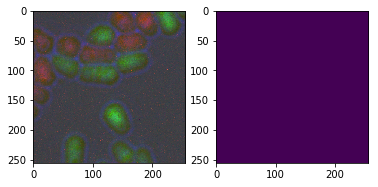

In [19]:
tb, tm = u.get_batch(2, erode=0)
tb = (tb - tb.min())/(tb.max() - tb.min())
print(tb.shape, tm.shape)
plt.subplot(1,2,1)
plt.imshow(tb[1,:,:,:])
plt.subplot(1,2,2)
plt.imshow(tm[-1,:,:,-1])

(256, 256, 9)


(256, 256)

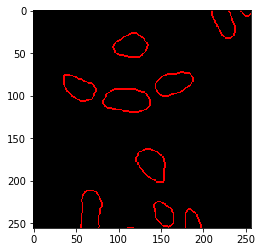

In [20]:
bz = tm[1]
print(bz.shape)
bz[:,:,-2] = 0

bzm = bz.max(axis=-1)
bz[:,:,-1] = 1 - bzm
plt.imshow(bz[:,:,-3:])
bzm.shape

In [21]:
u.stdev = 0.1
#u.learning_rate = 0.0001

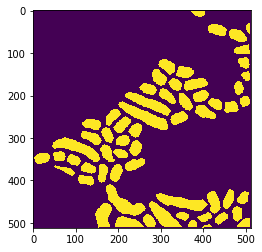

In [22]:
lc = labels.copy()
lc[:,:,:,4] = 0
plt.imshow(lc[5,:,:,:].sum(axis=-1))

0 2.3738294 2.3738294 0.00082975236 0.7883827 0.00198
10


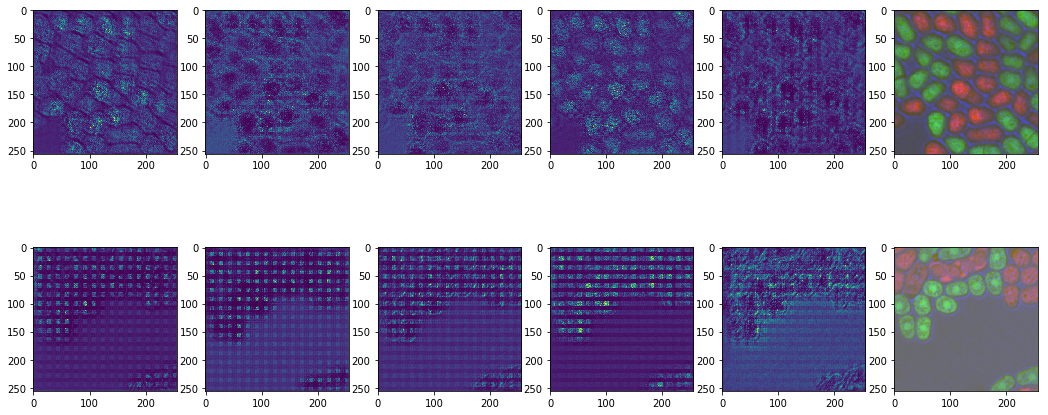

0 2.3738294 10.733847379684448 0.00198
10 0.72552705 2.032275676727295 0.0017906765085174325
20 0.5989808 1.9537200927734375 0.0016194557364425167
30 0.4692349 1.75008225440979 0.0014646067393087945
40 0.45219374 1.4683051109313965 0.0013245640819679666
50 0.4815594 1.479762077331543 0.0011979120129323219
60 0.40582848 1.9680848121643066 0.001083370151933707
70 0.3903873 1.3645920753479004 0.0009797805460084097
80 0.4211341 1.739084243774414 0.000886095963252345
90 0.3705271 1.5352208614349365 0.0008013693059030809
100 0.38951343 0.38951343 3.7205153e-20 1.0 0.0014494880714419874
7


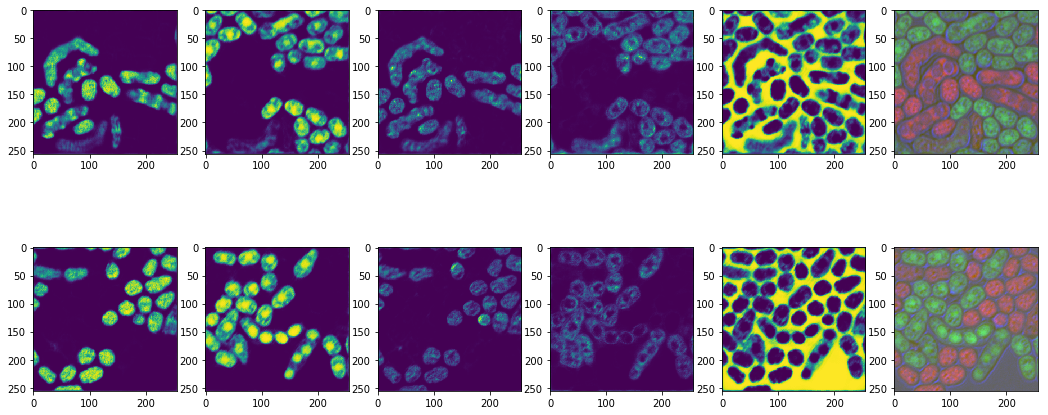

100 0.38951343 3.152290105819702 0.0014494880714419874
110 0.38475877 1.8652095794677734 0.001310891029751215
120 0.38576984 1.756896734237671 0.0011855463495968322
130 0.36013362 1.749279499053955 0.0010721868676674966
140 0.37338498 1.4527723789215088 0.0009696665841783208
150 0.37408242 1.3431577682495117 0.0008769490774658893
160 0.4065656 1.3473670482635498 0.0007930970263556577
170 0.3825274 1.9479899406433105 0.000717262734378842
180 0.35977453 1.5062925815582275 0.0006486795600440262
190 0.3855858 1.7593131065368652 0.000586654166528415
200 0.37720925 0.37720925 7.725259e-13 0.9999999 0.0010611190248750572
4


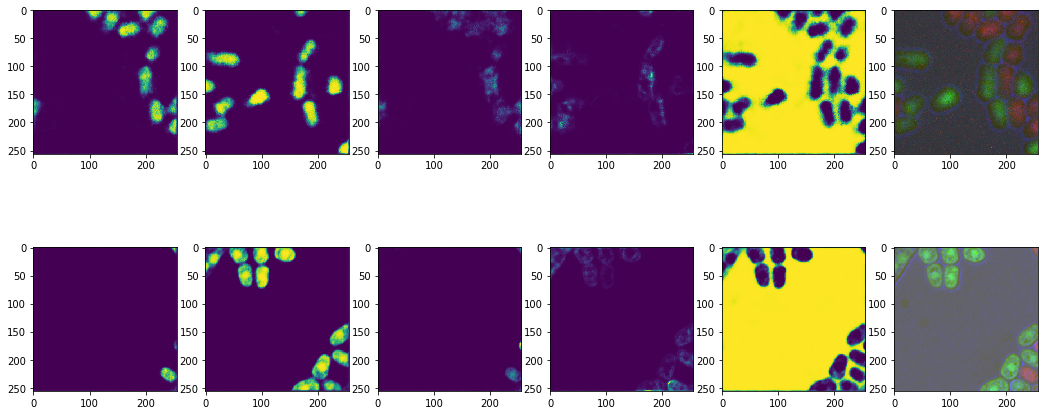

200 0.37720925 2.563903570175171 0.0010611190248750572
210 0.40721697 1.7737634181976318 0.0009596570255478233
220 0.3523633 1.7499616146087646 0.0008678966120617177
230 0.35391995 1.9732861518859863 0.0007849101389094876
240 0.36588222 1.777827262878418 0.0007098586601224113
250 0.3840882 1.3246047496795654 0.0006419834480044761
260 0.3691884 1.9821782112121582 0.0005805983228275952
270 0.35732278 1.5164337158203125 0.0005250827159454522
280 0.33012334 2.0073134899139404 0.00047487539619800673
290 0.36751574 1.5227227210998535 0.0004294687961841813
300 0.3421011 0.3421011 4.1232615e-14 0.99999964 0.0007768077620891664
10


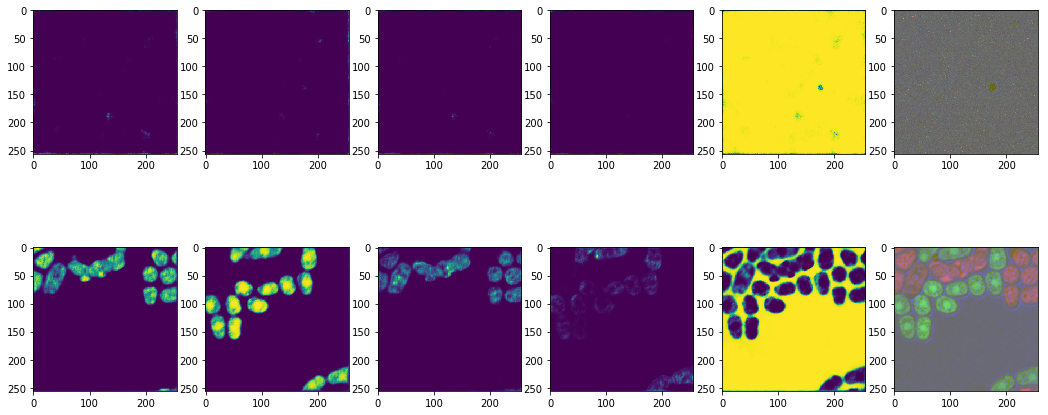

300 0.3421011 2.344215154647827 0.0007768077620891664
310 0.35089713 1.9768383502960205 0.000702531015761146
320 0.3466567 1.420769214630127 0.0006353564577921085
330 0.35331643 1.3379466533660889 0.000574604991668271
340 0.3818756 1.5325052738189697 0.0005196624546753677
350 0.39037722 2.1715238094329834 0.00046997340906347786
360 0.3474053 2.1417534351348877 0.0004250355268877898
370 0.32937133 2.0247340202331543 0.0003843945117592398
380 0.3178798 1.7177810668945312 0.0003476395061668176
390 0.35409385 1.3920972347259521 0.0003143989379421825
400 0.3322691 0.3322691 2.287656e-13 0.99954563 0.0005686735277534306
11


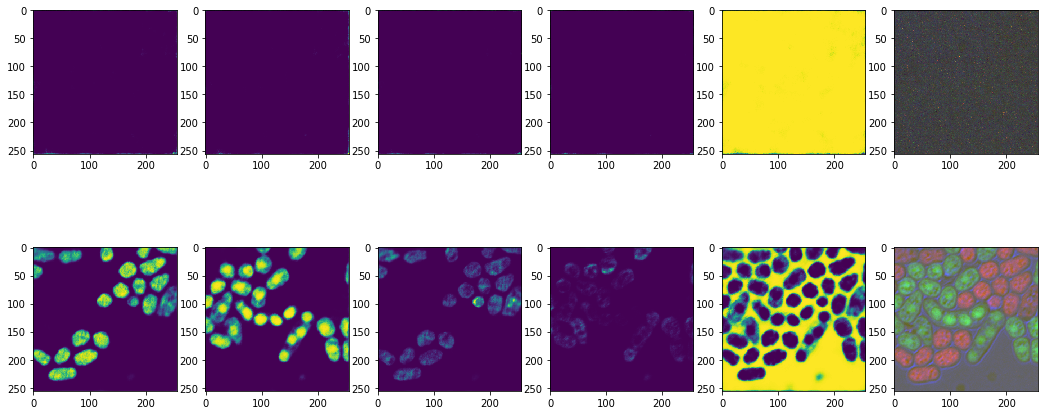

400 0.3322691 2.460059642791748 0.0005686735277534306
410 0.34172392 1.7343554496765137 0.0005142981450322247
420 0.3367226 1.3704144954681396 0.0004651220235774224
430 0.34540144 1.4499945640563965 0.00042064802081524333
440 0.3348401 1.9543302059173584 0.0003804265299132365
450 0.32778388 1.9451475143432617 0.00034405093451133186
460 0.370616 1.99137544631958 0.00031115349806207655
470 0.35449442 1.7725958824157715 0.0002814016462236288
480 0.3490281 1.374634027481079 0.00025449460472261884
490 0.35455248 1.7365775108337402 0.00023016035869758753
500 0.34673175 0.34673175 2.9432692e-20 0.9998597 0.0004163058055673899
6


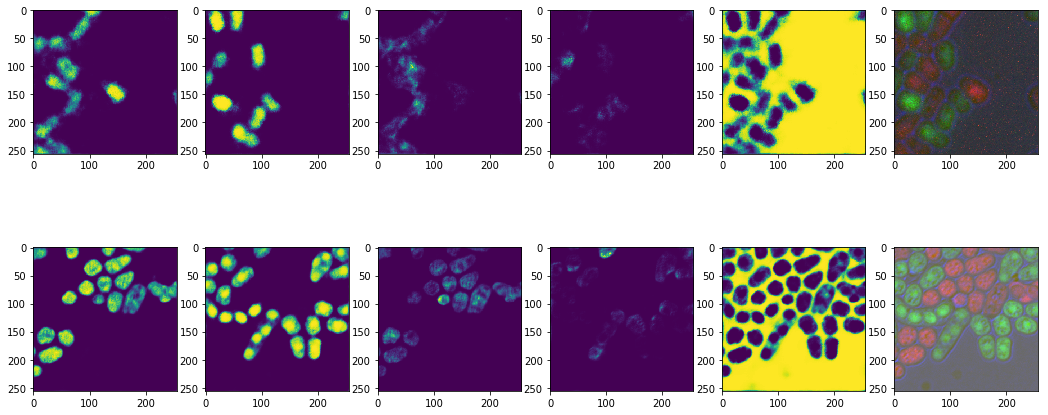

500 0.34673175 2.818333387374878 0.0004163058055673899
510 0.34669456 2.1342532634735107 0.0003764995082772479
520 0.33729634 1.3491442203521729 0.000340499406535572
530 0.3445559 1.958509922027588 0.00030794155982190704
540 0.33037487 1.5169682502746582 0.0002784968268531843
550 0.34869456 1.510791540145874 0.0002518675381528505
560 0.33516756 1.9872608184814453 0.00022778448678203414
570 0.34163436 1.761375904083252 0.00020600420681075163
580 0.33757168 1.9533615112304688 0.00018630651201605048
590 0.33906144 1.3406250476837158 0.00016849226992472852
600 0.32133576 0.32133576 2.6019372e-16 1.0 0.0003047627773949391
11


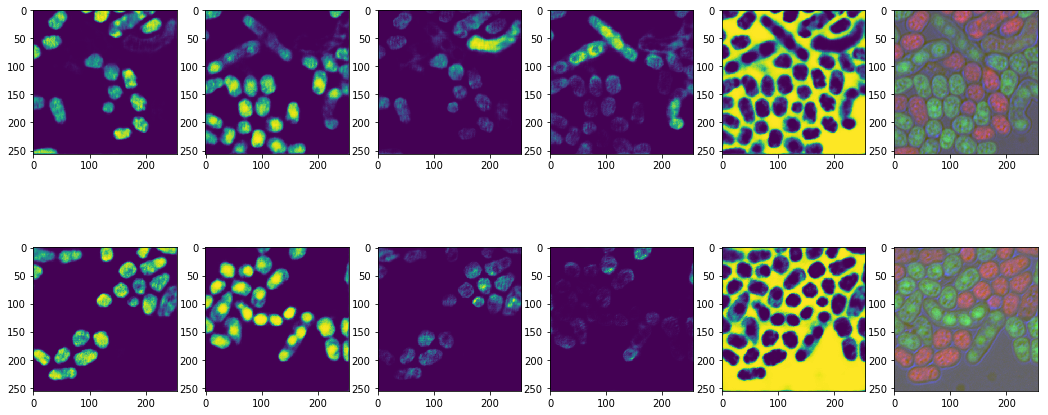

600 0.32133576 3.029029369354248 0.0003047627773949391
610 0.32059127 1.9918146133422852 0.00027562199300588133
620 0.33449635 1.523613452911377 0.00024926758995272107
630 0.34044126 1.3540279865264893 0.0002254331402338857
640 0.31959346 1.7796614170074463 0.00020387769114047237
650 0.33281705 1.5420544147491455 0.0001843833293616245
660 0.33097786 1.3616809844970703 0.0001667529780050978
670 0.32568586 1.7340633869171143 0.0001508084042621479
680 0.3066634 2.0020010471343994 0.00013638841757536793
690 0.32638624 1.5157866477966309 0.00012334724009397852
700 0.33552998 0.33552998 1.2266762e-14 0.99998987 0.00022310606588560298
13


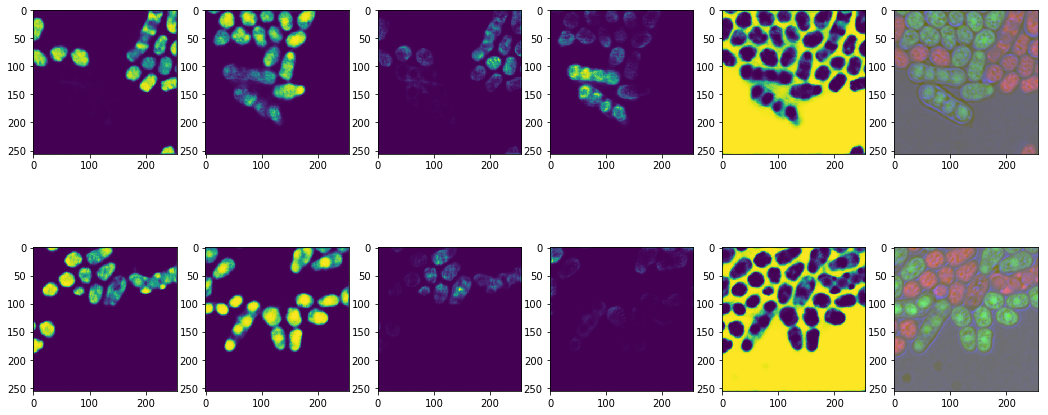

700 0.33552998 2.5252017974853516 0.00022310606588560298
710 0.32435292 1.3552451133728027 0.00020177312681267268
720 0.33027986 1.3228847980499268 0.00018247999910785955
730 0.34389645 1.9313337802886963 0.00016503164024077077
740 0.30661148 1.7581663131713867 0.0001492516572430548
750 0.30893144 1.7255191802978516 0.00013498052347597677
760 0.29316783 1.5333995819091797 0.00012207396590697853
770 0.33072487 1.794492483139038 0.00011040150659150728
780 0.33148605 2.1752769947052 9.984514361532555e-05
790 0.27603972 1.5211539268493652 9.02981581623802e-05
800 0.2831182 0.2831182 1.8185213e-19 1.0 0.00016332807129673327
15


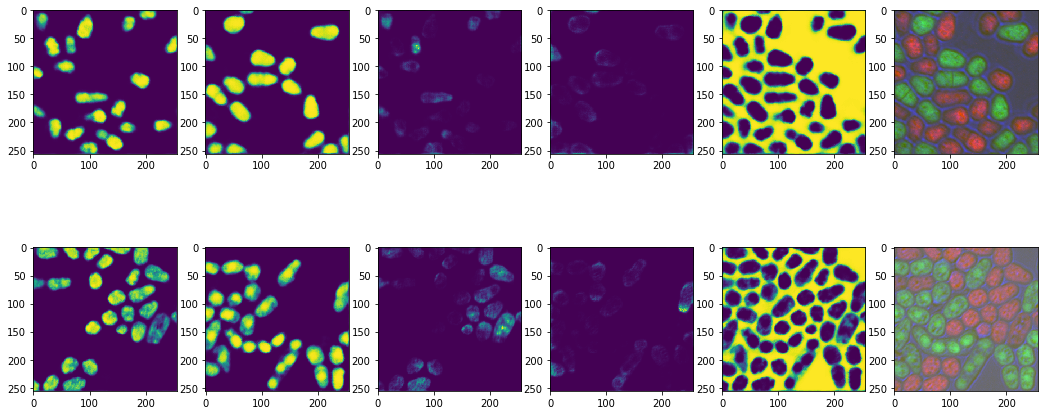

800 0.2831182 2.4564740657806396 0.00016332807129673327
810 0.3323123 1.3342680931091309 0.00014771098002652557
820 0.32177716 1.7472610473632812 0.00013358716261797327
830 0.3202951 1.329789638519287 0.00012081383532298126
840 0.33010447 1.339184045791626 0.00010926186707916977
850 0.3494118 1.7218589782714844 9.881447406839571e-05
860 0.30646792 1.5072147846221924 8.936603909887939e-05
870 0.32411855 1.3157942295074463 8.082104387556249e-05
880 0.31892067 1.7364356517791748 7.309310336455881e-05
890 0.32279235 1.7622795104980469 6.61040924896727e-05
900 0.34034884 0.34034884 7.524209e-15 0.99886453 0.00011956671266476822
14


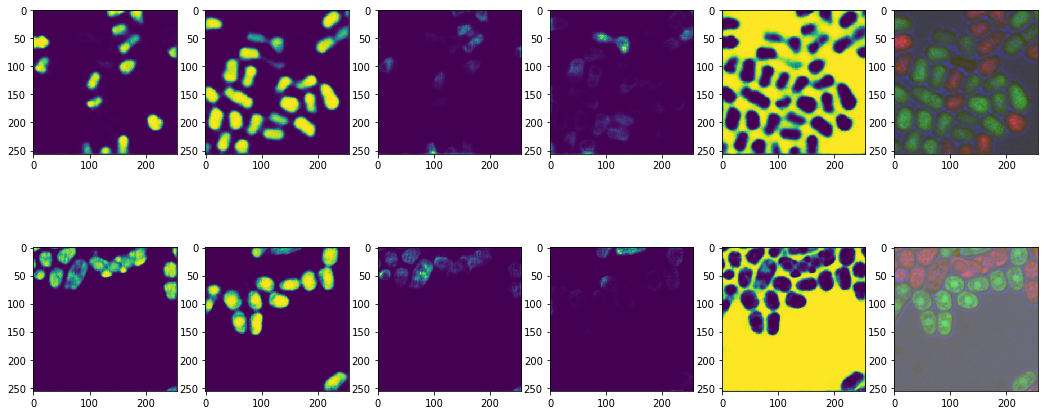

900 0.34034884 2.373760223388672 0.00011956671266476822
910 0.33155134 1.743206262588501 0.00010813399170174457
920 0.3146498 1.3513696193695068 9.77944437942086e-05
930 0.31978917 1.9193918704986572 8.844354200293825e-05
940 0.3108952 1.3417680263519287 7.998675403774567e-05
950 0.3130388 1.9976367950439453 7.233858658987529e-05
960 0.27837664 1.9788293838500977 6.542172104335548e-05
970 0.31666917 1.3289105892181396 5.9166231827837e-05
980 0.3595794 1.337216854095459 5.350887951091119e-05
990 0.32606643 1.5214710235595703 4.8392471483473974e-05
1000 0.3381338 0.3381338 6.3836565e-20 0.9998635 8.753056755005719e-05
15


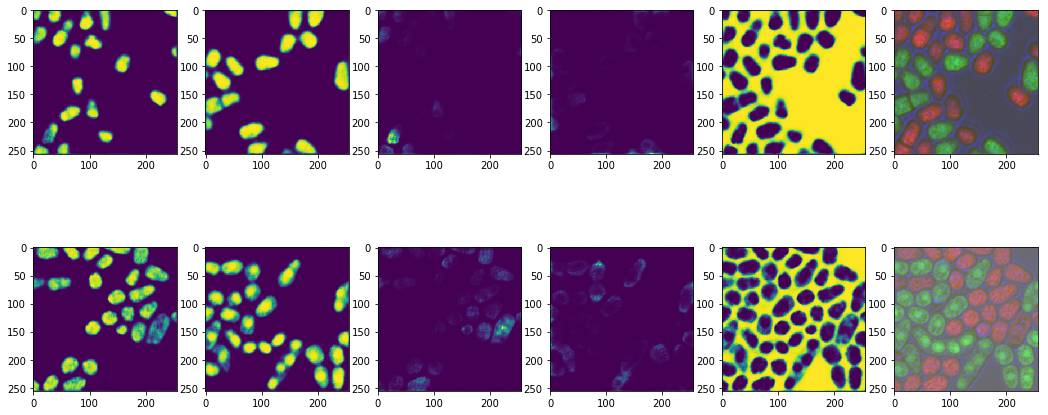

1000 0.3381338 2.8743298053741455 8.753056755005719e-05
1010 0.3270919 1.9672064781188965 7.916107630761903e-05
1020 0.29705283 1.5048372745513916 7.159185845101478e-05
1030 0.3211723 1.997849702835083 6.474639349966535e-05
1040 0.3010521 2.0152463912963867 5.8555477702563925e-05
1050 0.3088175 1.3999195098876953 5.295652442777655e-05
1060 0.31262812 1.3554294109344482 4.7892931447246984e-05
1070 0.30854142 1.7485601902008057 4.331350872051564e-05
1080 0.3029837 1.3746345043182373 3.9171960892571886e-05
1090 0.3216498 1.35805082321167 3.54264192741879e-05
1100 0.30526918 0.30526918 6.2776407e-25 0.9998325 6.407803714664391e-05
8


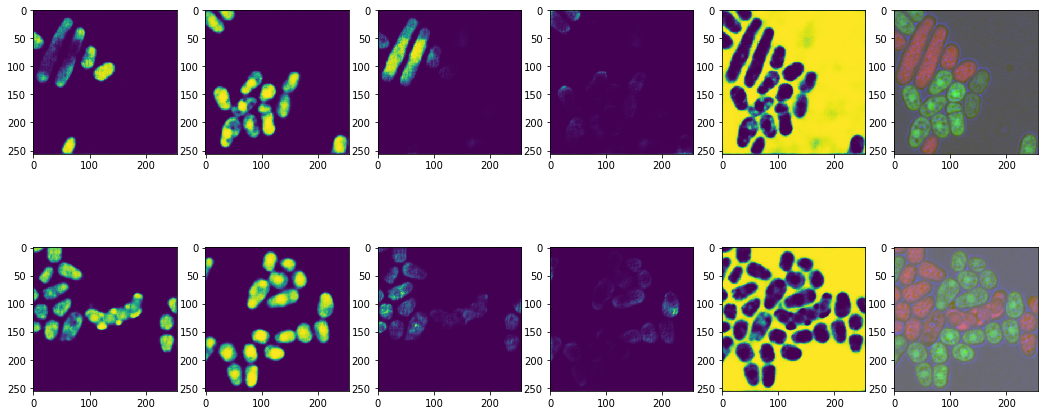

1100 0.30526918 2.846694231033325 6.407803714664391e-05
1110 0.31772554 1.531916618347168 5.7951028197173066e-05
1120 0.2845291 1.7735064029693604 5.2409871129853114e-05
1130 0.30698872 1.5550239086151123 4.7398548003360595e-05
1140 0.32973385 1.769282341003418 4.286639719568367e-05
1150 0.3067634 1.7603659629821777 3.8767601243984e-05
1160 0.29993606 1.9842162132263184 3.5060723656148154e-05
1170 0.32252055 1.3587820529937744 3.170829001145754e-05
1180 0.278343 1.5292119979858398 2.8676409115542924e-05
1190 0.2785879 1.5499212741851807 2.59344303797161e-05
1200 0.31410193 0.31410193 3.8820126e-15 0.9999907 4.690926792195804e-05
12


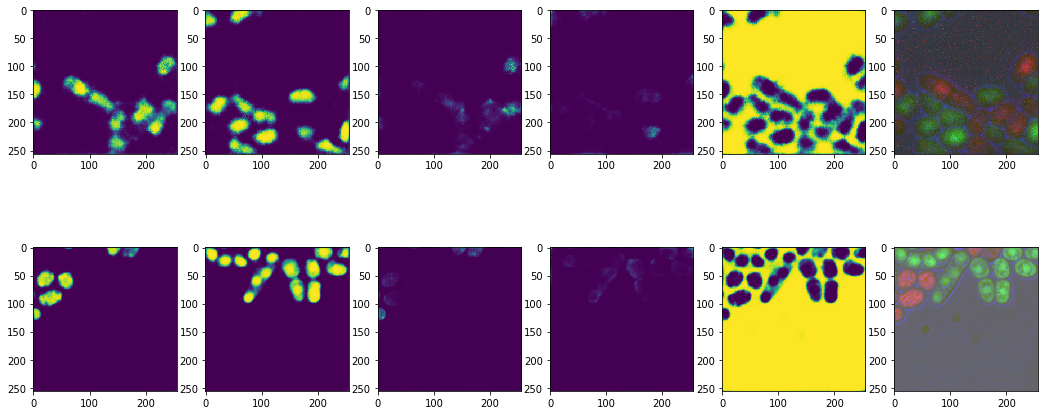

1200 0.31410193 2.361013650894165 4.690926792195804e-05
1210 0.28474328 1.9427449703216553 4.2423901060404354e-05
1220 0.27639082 1.3704311847686768 3.836741567097671e-05
1230 0.30863562 2.2172036170959473 3.4698802997243235e-05
1240 0.30432117 1.5522921085357666 3.138097545496856e-05
1250 0.31193942 1.7637429237365723 2.838039169776483e-05
1260 0.2954939 1.5324375629425049 2.5666717533187202e-05
1270 0.30775052 1.3552238941192627 2.3212519261328706e-05
1280 0.30358583 1.3454549312591553 2.099298633574229e-05
1290 0.31656823 1.5477604866027832 1.898568054295009e-05
1300 0.27865684 0.27865684 1.4064314e-15 0.9997497 3.434061832977497e-05
3


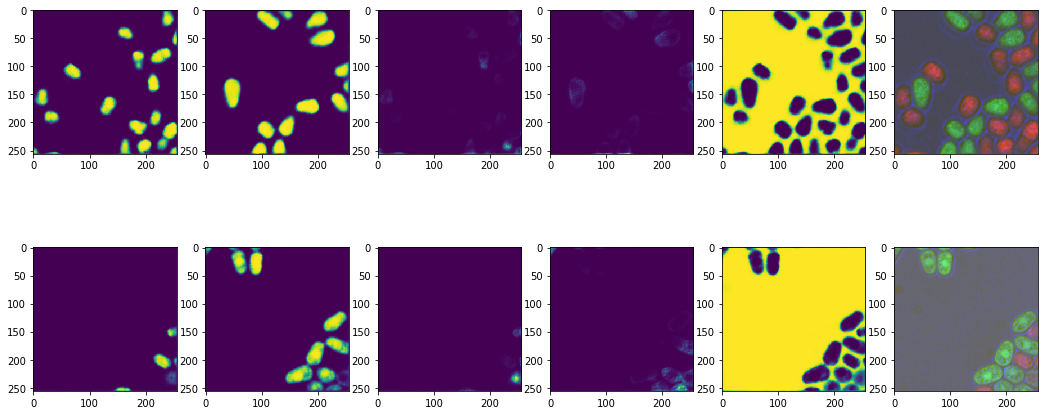

1300 0.27865684 3.1290335655212402 3.434061832977497e-05
1310 0.31497693 1.5257244110107422 3.105703966216727e-05
1320 0.30446544 1.381253719329834 2.8087429973301576e-05
1330 0.309383 1.7661495208740234 2.540176820091897e-05
1340 0.31838673 1.9769093990325928 2.2972903834439766e-05
1350 0.284119 1.8131706714630127 2.0776282438768356e-05
1360 0.2941947 1.5323622226715088 1.878969742294231e-05
1370 0.30186272 1.3558728694915771 1.699306554414815e-05
1380 0.31024486 1.897127628326416 1.5368223877577324e-05
1390 0.31321862 1.5530641078948975 1.3898746199603237e-05
1400 0.30725288 0.30725288 2.9065626e-26 0.99999595 2.5139553856035824e-05
12


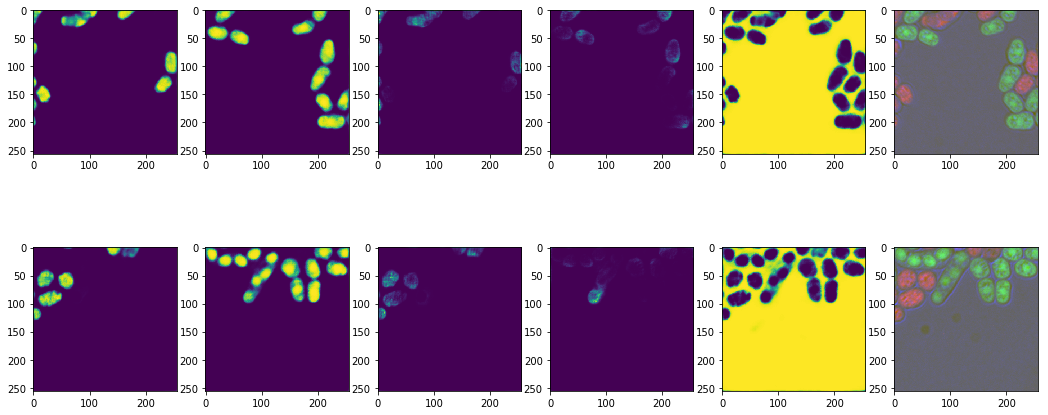

1400 0.30725288 2.5773582458496094 2.5139553856035824e-05
1410 0.28550786 1.801689624786377 2.273576188111727e-05
1420 0.2940134 1.8036022186279297 2.056181550695091e-05
1430 0.31620377 1.5624711513519287 1.8595737374124478e-05
1440 0.32326084 1.793421983718872 1.6817651552729472e-05
1450 0.2805238 1.399778127670288 1.5209582608032518e-05
1460 0.32028192 2.186552047729492 1.375527387907027e-05
1470 0.30627012 1.3942642211914062 1.2440023133067979e-05
1480 0.29685217 1.3811211585998535 1.1250533934241547e-05
1490 0.29922953 1.5195121765136719 1.017478122440634e-05
1500 0.3001846 0.3001846 7.612642e-23 0.9999994 1.840377951297846e-05
13


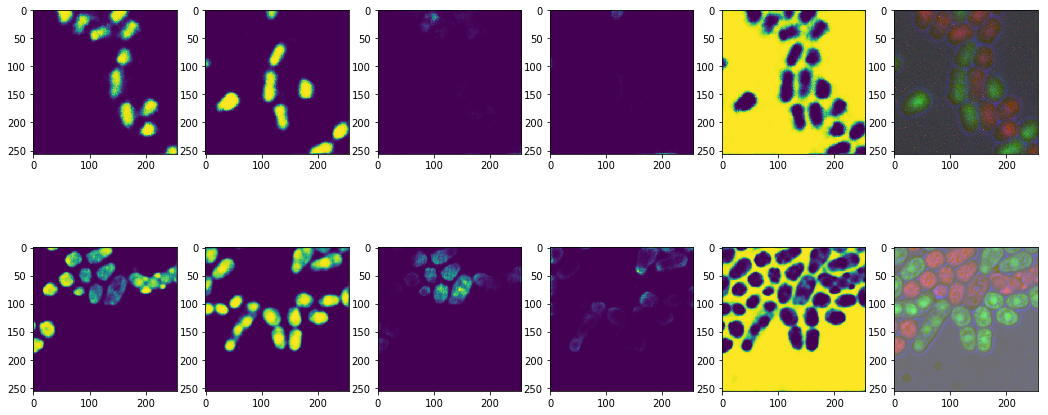

1500 0.3001846 2.630105495452881 1.840377951297846e-05
1510 0.27799478 2.027167558670044 1.6644048303951983e-05
1520 0.2921036 1.8467352390289307 1.5052578941674871e-05
1530 0.31698126 1.60125732421875 1.3613282577505754e-05
1540 0.30479467 1.8386917114257812 1.2311608745125859e-05
1550 0.29742482 2.0125627517700195 1.1134398263613468e-05
1560 0.30221704 1.3827800750732422 1.0069750205621178e-05
1570 0.29736254 1.565356969833374 9.106901585780014e-06
1580 0.28957438 1.8109862804412842 8.236118553048702e-06
1590 0.3066121 1.9014620780944824 7.448597987024696e-06
1600 0.32422122 0.32422122 3.0761446e-24 0.99998605 1.3472757006823596e-05
12


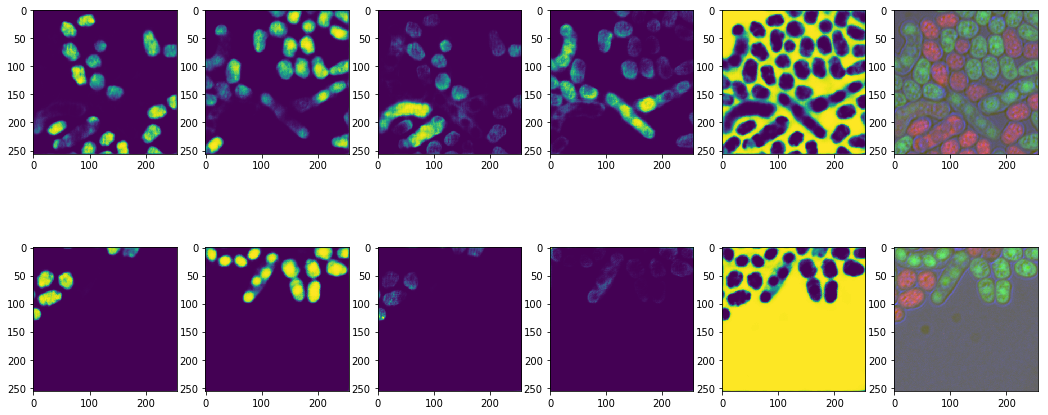

1600 0.32422122 2.9920434951782227 1.3472757006823596e-05
1610 0.303829 1.5598316192626953 1.2184519937920533e-05
1620 0.29552072 1.862910270690918 1.1019461424442721e-05
1630 0.28767502 1.5286145210266113 9.965803388516984e-06
1640 0.31114587 1.977367639541626 9.012893947636764e-06
1650 0.32006603 1.9811463356018066 8.151099730198033e-06
1660 0.28266838 1.9563086032867432 7.3717084876002e-06
1670 0.3192431 1.3576998710632324 6.666841018375885e-06
1680 0.32336602 1.998051643371582 6.029371513952594e-06
1690 0.29684323 1.9760210514068604 5.452855520787424e-06
1700 0.33830267 0.33830267 7.1049e-19 0.99976295 1e-05
0


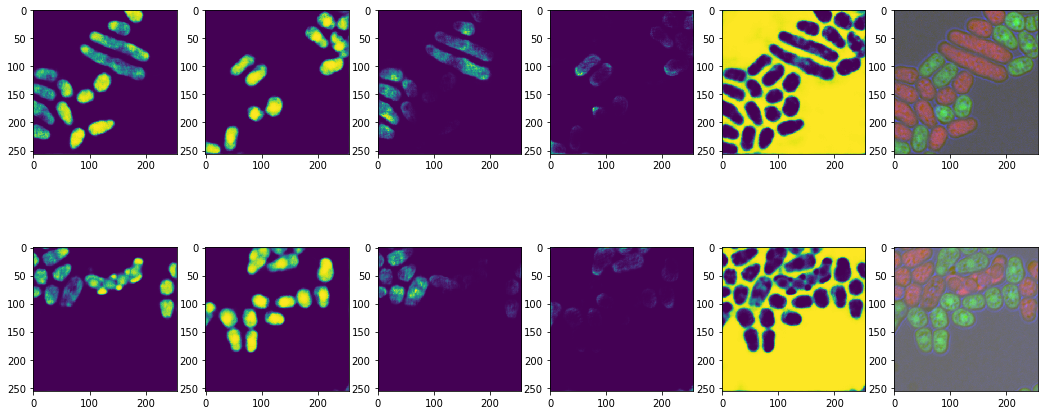

1700 0.33830267 2.4109065532684326 1e-05
1710 0.31271315 1.9981541633605957 9.043820750088042e-06
1720 0.3065539 1.9914186000823975 8.179069375972305e-06
1730 0.31279203 2.24788498878479 7.397003733882799e-06
1740 0.27832797 1.356142282485962 6.6897175856968e-06
1750 0.29303312 2.0045206546783447 6.05006067137536e-06
1760 0.2843309 2.183384418487549 5.4715664239076095e-06
1770 0.32766327 1.7452597618103027 5e-06


KeyboardInterrupt: 

In [23]:

rate = 0.002
#loss_file = open('progress.dat', 'w', buffering=1)

tbx, _ = u.get_batch(16, test=True, erode=0)
for i in range(2500):
    t1 = time.time()
    rate = np.maximum(rate*.99, 0.000005)
    bx, bm = u.get_batch(256, erode=0)
#     plt.figure(figsize=(2,2))
#     plt.imshow(bm[0])
    _, res, err = sess.run([u.opt, u.decoder_softmax, u.loss],
                           feed_dict={images:bx, masks:bm, learning_rate:rate})
    if i % 100 == 0:
        if i > 0:
            rate *= 2
        print(i, err, err, res[0,:,:,:].min(), res[0,:,:,:].max(), rate)
        nr = np.random.randint(0,16)
        #nr = np.argmin(res[:,:,:,4].sum(axis=(1,2)))
        print(nr)
        
        tres = sess.run(u.decoder_softmax,
                           feed_dict={images:tbx, learning_rate:rate})
        
        plt.figure(figsize=(18,8))
        plt.subplot(2,6,1)
        plt.imshow(res[nr,:,:,0])
        plt.subplot(2,6,2)
        plt.imshow(res[nr,:,:,1])
        plt.subplot(2,6,3)
        plt.imshow(res[nr,:,:,2])
        plt.subplot(2,6,4)
        plt.imshow(res[nr,:,:,3])
        plt.subplot(2,6,5)
        plt.imshow(res[nr,:,:,4])
        plt.subplot(2,6,6)
        bxd = bx[nr,:,:,:]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        
        plt.subplot(2,6,7)
        plt.imshow(tres[nr,:,:,0])
        plt.subplot(2,6,8)
        plt.imshow(tres[nr,:,:,1])
        plt.subplot(2,6,9)
        plt.imshow(tres[nr,:,:,2])
        plt.subplot(2,6,10)
        plt.imshow(tres[nr,:,:,3])
        plt.subplot(2,6,11)
        plt.imshow(tres[nr,:,:,4])
        plt.subplot(2,6,12)
        bxd = tbx[nr,:,:,:]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        
    
#         plt.imshow(res[nr,:,:,5])
#         plt.subplot(2,5,7)
#         plt.imshow(res[nr,:,:,6])
#         plt.subplot(2,5,8)
#         plt.imshow(res[nr,:,:,7])
#         plt.subplot(2,5,9)
#         plt.imshow(res[nr,:,:,8])
#         plt.subplot(1,6,4)
#         plt.imshow(res[nr,:,:,1])
#         plt.subplot(1,6,5)
#         plt.imshow(bm[nr,:,:,1])
#         plt.subplot(1,6,6)
#         plt.imshow(bx[nr,:,:,1])
        plt.show()
        #plt.savefig("images/image{0:05d}".format(i))
    t2 = time.time()
    if i % 10 == 0:
        print(i, err, (t2 - t1), rate)


In [24]:
na = 13
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
print(bm.shape)
plt.imshow(res[na,:,:,0:3])
plt.subplot(1,3,2)
plt.imshow(bm[na,:,:,0:3])
plt.subplot(1,3,3)
plt.imshow(bx[na,:,:,:])


(256, 256, 256, 9)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fbc581a8840> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

In [23]:
plt.hist(res[na,:,:,:].reshape((-1,3)))

ValueError: cannot reshape array of size 327680 into shape (3)

In [28]:
import os
os.listdir('/ssd1/cjw/Data/sez/RawTifs/')

['16_hours_punched_overnight',
 '10_hours_punched_overnight',
 '.DS_Store',
 'NDExp_Point0007_Seq0007.tif',
 'NDExp_Point0021_Seq0021.tif',
 'NDExp_Point0023_Seq0023.tif',
 'NDExp_Point0022_Seq0022.tif',
 'NDExp_Point0004_Seq0004.tif',
 'NDExp_Point0024_Seq0024.tif']

In [29]:
#test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/16_hours_punched_overnight/NDExp_Point0008_Seq0008.tif')
test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0007_Seq0007.tif')
#test_tif = labels[-1,:,:,:] #imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0021_Seq0021.tif')
ymax = test_tif.max(axis=(0,1), keepdims=True)
ymin = test_tif.min(axis=(0,1), keepdims=True)
ymean = test_tif.mean(axis=(0,1), keepdims=True)
ystd = test_tif.std(axis=(0,1), keepdims=True)
#test_tif = (test_tif - ymin)/(ymax - ymin + 0.00001)
test_tif = (test_tif - ymean)/ystd
test_tif.shape, ymin.shape

((2044, 2048, 3), (1, 1, 3))

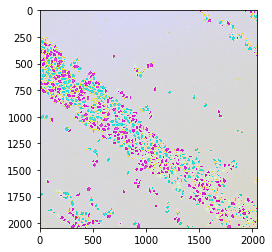

In [36]:
plt.imshow((test_tif[:,:,0:3] - test_tif[0:3].min())/test_tif[:,:,0:3].max() - test_tif[:,:,0:3].min())

In [37]:
def make_batch(data, start = 0):
    tclist = list()
    print(start)
    ix = start
    jy = start
    for i in range(6):
        jy = start
        for j in range(6):
            p = data[jy:jy + 256, ix:ix + 256,:]
            p = np.expand_dims(p, 0)
            tclist.append(p)
            jy = jy + 256
            #print(i, j, ix, jy)
        ix += 256

    tc = np.concatenate(tclist, axis=0)
    return tc

tc0 = make_batch(test_tif,start=0)
tc1 = make_batch(test_tif, start=128)
tc0.shape, tc1.shape

0
128


((36, 256, 256, 3), (36, 256, 256, 3))

In [38]:
vres0 = sess.run(u.decoder_softmax,
                feed_dict={images:tc0})

vres1 = sess.run(u.decoder_softmax,
                feed_dict={images:tc1})
vres0.shape, vres1.shape

((36, 256, 256, 9), (36, 256, 256, 9))

In [40]:
def reconstruct(v1, w, nx, ny, offset=0, pad=0):
    p = np.zeros((ny*w + pad, nx*w + pad, 9), dtype=np.float32)

    ix = offset
    jy = offset
    index = 0
    for i in range(nx):
        jy = offset
        for j in range(ny):
            p[jy:jy + 256, ix:ix + 256, :] = v1[index]
            jy = jy + 256
            index += 1
            #print(i, j, ix, jy)
        ix += 256
    return p
r0 = reconstruct(vres0, 256, 6, 6, offset=0, pad=128)
r1 = reconstruct(vres1, 256, 6, 6, offset=128, pad = 128)

r0 = np.expand_dims(r0, 0)
r1 = np.expand_dims(r1, 0)
r = np.concatenate([r0, r1])
r  = r.max(axis=(0))
r.shape, r.max()

((1664, 1664, 9), 0.9999949)

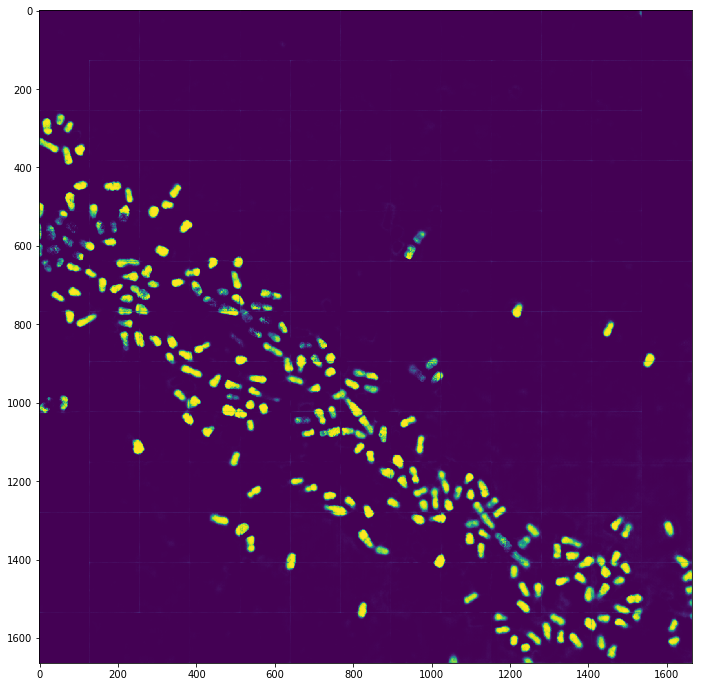

In [43]:

plt.figure(figsize=(12,12))

# az = r*0
# az[:,:,0] = r[:,:,-1]
# az[:,:,1] = r[:,:,-1]
# az[:,:,2] = r[:,:,-1]
# az = r - az

#plt.subplot(1,3,1)
plt.imshow(r[:,:,0]) #0[0,150:350,100:300,1])

#plt.subplot(1,3,4)
#plt.imshow(r0[0]) #[0,150:350,100:300,1])

#plt.subplot(1,3,3)
#plt.imshow(r1[0]) #[150:350,100:300,1])

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(test_tif[0:6*256+128, 0:6*256+128, :])

In [ ]:
plt.imshow(tc0[0,:,:,0])

In [ ]:
import tifffile
r.shape

In [ ]:
tifffile.imsave('/ssd1/cjw/Data/sez/unetout0017-2.tif', np.moveaxis(r, -1, 0))

In [ ]:
from skimage.morphology import binary_erosion

blab = labels[2, :,:,1]
plt.subplot(1,2,1)
plt.imshow(blab)
plt.subplot(1,2,2)
plt.imshow(binary_erosion(binary_erosion(blab)))
labels.shape

In [ ]:
plt.imshow(data[6,:,:,0:3])

In [ ]:
!%mkdir '/ssd1/cjw/sez/unet_checkpoint'

In [30]:
saver = tf.train.Saver()
saver.save(sess, '/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint', global_step=5000)

'/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint-5000'